Coda energy plot
====

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import numpy as np
from scipy.signal import hilbert
from sbp_modelling.single_source.model import SingleSourceModel, v_p_0, v_p_1
from sbp_modelling.single_source.analysis import depth_to_time, waterbottom, mtd_top, mtd_base
from sbp_modelling.analysis import envelope
import pandas as pd
import matplotlib.transforms as transforms
import matplotlib.ticker as ticker
from cycler import cycler
from collections import defaultdict
from examples.seismic import RickerSource, TimeAxis
from string import ascii_lowercase

plt.style.use('./mpl/manuscript.mplstyle')

SBP_CACHE_PATH unset
Loaded from cache /tmp/sbp_0bbde8f4acbab8e3a8c950340b5244ab.npz


Operator `initdamp` ran in 0.01 s
Operator `pad_lam` ran in 0.01 s
Operator `pad_mu` ran in 0.01 s
Operator `pad_b` ran in 0.01 s


400
SBP_CACHE_PATH unset
Loaded from cache /tmp/sbp_0bbde8f4acbab8e3a8c950340b5244ab.npz
11.553814111140841


In [2]:
results_path = '../../results/single-source/traces.npz'

loaded = np.load(results_path)

params = loaded['params']
data_raw = loaded['data'].T
t = loaded['t']

In [3]:
model = SingleSourceModel()
waterbottom, mtd_top, mtd_base = model.horizons()

wb = depth_to_time(waterbottom, offset=True)
t_start = depth_to_time(mtd_top, offset=True)
t_end = depth_to_time(mtd_base, offset=True)

t_ind = (t > t_start) & (t < t_end)
t_ind.shape, t_start, t_end

((4370,), 22.145173247054437, 32.23908263799353)

In [4]:
data = envelope(data_raw)
factor = 1.5 / data[t_ind, :].max()
data *= factor

In [5]:
a_x_s = list(np.unique(params[:, 0]))
_a_z_s = list(np.unique(params[:, 1]))

In [6]:
def label_axis(axis, i, offset=(-25, 0)):
    axis.annotate(f'{ascii_lowercase[i]})', xy=(0, 1), xytext=offset,
                   textcoords='offset points', xycoords='axes fraction', va='center', ha='right')

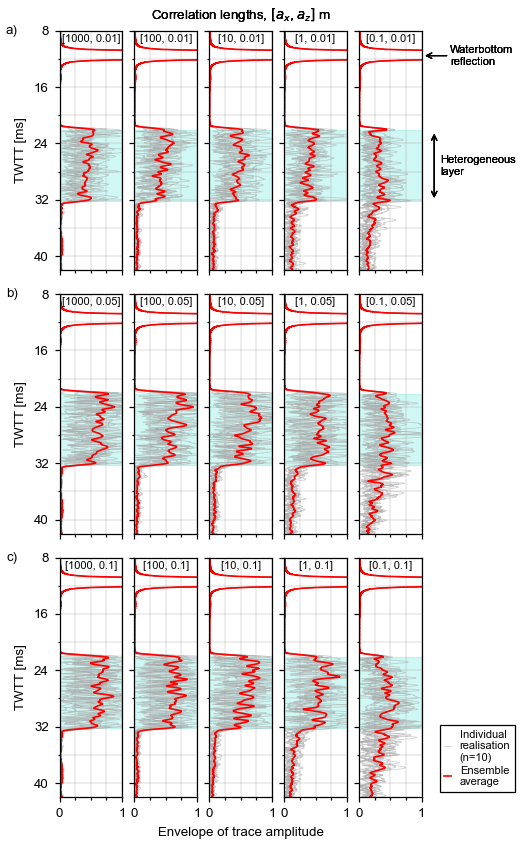

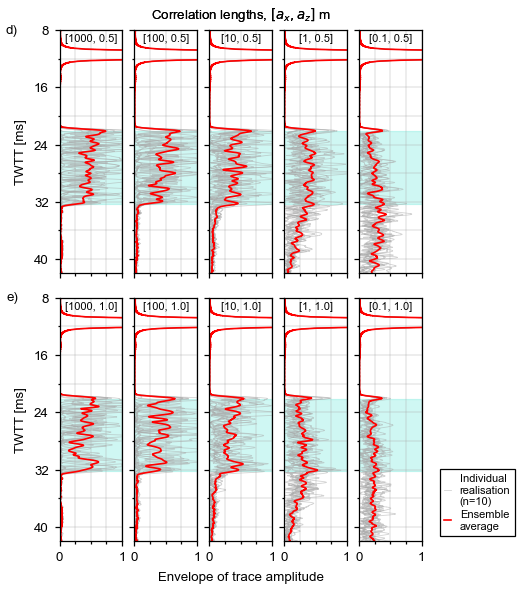

In [7]:
n_page_1 = 3
for k, a_z_s in enumerate([_a_z_s[0:n_page_1], _a_z_s[n_page_1:]]):
    plt.rcParams['figure.figsize'][1] = plt.rcParams['figure.figsize'][0] * len(a_z_s) * 1.8 / 3
    fig, ax = plt.subplots(len(a_z_s), 6, constrained_layout=False,
                            sharey=True, sharex=True,
                            gridspec_kw=dict(hspace=0.1))

    for j, a_z in enumerate(a_z_s):
        ax[j, 0].set(ylabel='TWTT [ms]')
        ax[j, -1].axis('off')
        want_params = (1000, a_z), (100, a_z), (10, a_z), (1, a_z), (0.1, a_z)
        for i, (a_x, a_z) in enumerate(want_params):
            ax[j, i].annotate(f'[{round(a_x, 2)}, {round(a_z, 2)}]', xy=(0.5, 1), xytext=(0, -2),
                xycoords='axes fraction', textcoords='offset points', ha='center', va='top', fontsize='small')

            ind = (params[:, 0] == a_x) & (params[:, 1] == a_z)
            n = np.sum(ind)

            if n == 0:
                # If we don't find any run with these parameters, skip
                continue

            ax[j, i].axhspan(t_start, t_end, color='turquoise', alpha=0.25, zorder=-999)

            ax[j, i].plot(data[:, ind], t, color='darkgray', alpha=0.5, linewidth=0.5,
                       label='Individual\nrealisation\n(n={})'.format(data[:, ind].shape[1]))
            ax[j, i].plot(np.sqrt(np.square(data[:, ind]).mean(axis=1)), t, linewidth=1.0,
                       color='red', label='Ensemble\naverage')

            ax[j, i].set(ylim=(8, 42), xlim=(0, 1.0), yticks=np.arange(8, 42, 8)) # lim
            ax[j, i].invert_yaxis()
            ax[j, i].xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
            ax[j, i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
            ax[j, i].grid('on', which='both')

        handles, labels = ax[0, i].get_legend_handles_labels()
        handles[0] = Line2D([0], [0], color='darkgray', lw=0.75)
        by_label = dict(zip(labels, handles))
        ax[-1, -1].legend(by_label.values(), by_label.keys(), title='', loc='lower left',
                      frameon=True, framealpha=1., edgecolor='k', fancybox=False, fontsize='small')

        if k == 0:
            ax[0, -1].annotate('Heterogeneous\nlayer', xy=(0.1, (t_start + t_end) / 2), xytext=(0, 0),
                           textcoords='offset points', ha='left', va='center', fontsize='small')
            ax[0, -1].annotate('', xy=(0, t_start), xytext=(0, t_end),
                            textcoords='data', arrowprops=dict(arrowstyle='<->'))

            ax[0, -1].annotate('Waterbottom\nreflection', xy=(0.25, wb), xytext=(0, 0),
                           textcoords='offset points', ha='left', va='center', fontsize='small')
            ax[0, -2].annotate('', xy=(1, wb), xytext=(17, 0),
                            textcoords='offset points', arrowprops=dict(arrowstyle='->'))

        ax[-1, 2].set_xlabel('Envelope of trace amplitude', ha='center')
        ax[0, 2].annotate('Correlation lengths, $[a_x, a_z]$ m', xy=(0.5, 1), xytext=(0, 4),
            xycoords='axes fraction', textcoords='offset points', va='bottom', ha='center')

    for i, a in enumerate(ax[:, 0]):
        label_axis(a, i + n_page_1 * k)

    fig.savefig(f'../../manuscript/figures/si_fig03_pg_{k+1}.pdf')